<a href="https://colab.research.google.com/github/devikamsba2024/Machine_Learning/blob/main/CIFAR_PCA_UMAP_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install umap-learn

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
import umap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [ ]:
# Load CIFAR-10 dataset without train-test split
dataset = tfds.load('cifar10', split='all', as_supervised=True, shuffle_files=True)

# Display dataset structure
print(dataset)

# Function to preprocess the dataset (optional)
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1] range
    return image, label

# Apply preprocessing
dataset = dataset.map(preprocess)

# Iterate and print a sample
for image, label in dataset.take(1):
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Image shape: (32, 32, 3), Label: 7


In [ ]:
# Count the number of images in the dataset
num_images = sum(1 for _ in dataset)
print(f"Total number of images in the dataset: {num_images}")

Total number of images in the dataset: 60000


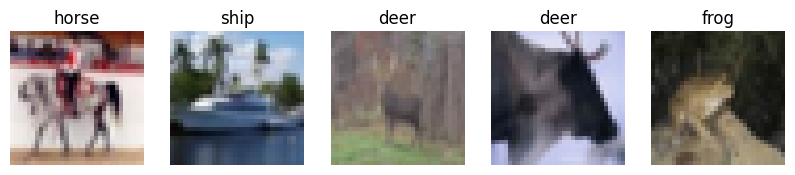

In [ ]:
# Define class names for CIFAR-10 dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Function to display the first 5 images with labels
def show_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))

    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.numpy())  # Convert tensor to NumPy array
        plt.title(class_names[label.numpy()])
        plt.axis('off')

    plt.show()

# Display the first 5 images and their labels
show_images(dataset)

In [ ]:
# Convert dataset to NumPy arrays
images, labels = [], []
for image, label in tfds.as_numpy(dataset):
    images.append(image.flatten())  # Flatten 32x32x3 -> 3072
    labels.append(label)

In [ ]:
# Convert lists to NumPy arrays
X = np.array(images)  # Shape: (num_samples, 3072)
y = np.array(labels)  # Labels

# Normalize pixel values to [0,1] range
X = X / 255.0

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

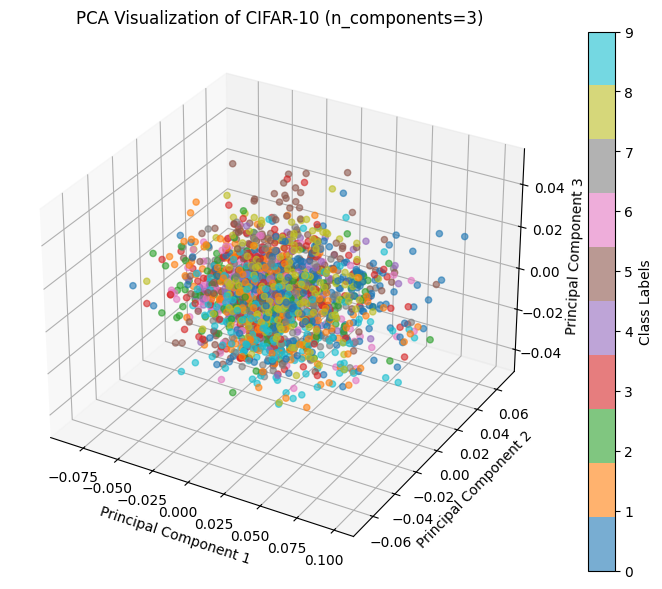

In [ ]:
# Plot PCA components in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with first 2000 samples for visualization
scatter = ax.scatter(X_pca[:2000, 0], X_pca[:2000, 1], X_pca[:2000, 2],
                      c=y[:2000], cmap='tab10', alpha=0.6)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("PCA Visualization of CIFAR-10 (n_components=3)")
plt.colorbar(scatter, ax=ax, label="Class Labels")
plt.show()

In [ ]:
# Apply UMAP for dimensionality reduction (3D)
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


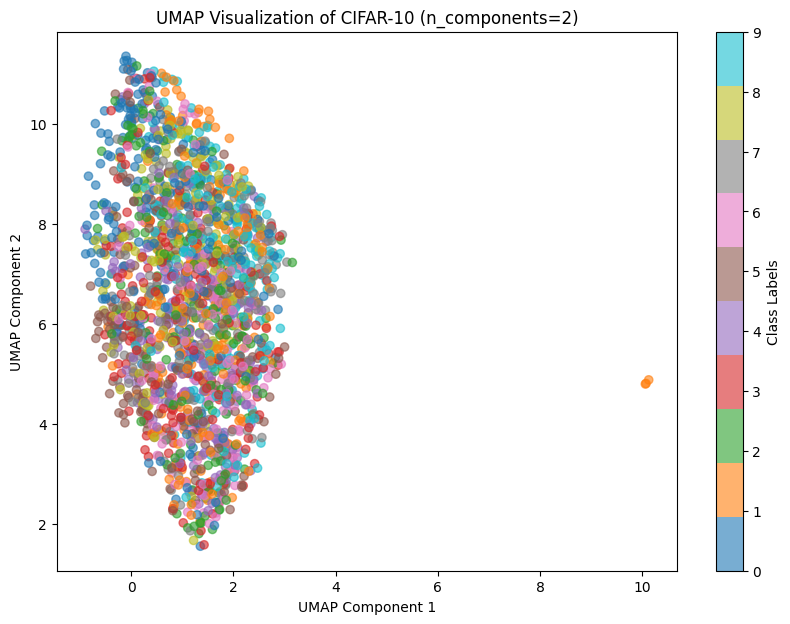

In [ ]:
# Plot UMAP components in 2D
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_umap[:2000, 0], X_umap[:2000, 1], c=y[:2000], cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Class Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP Visualization of CIFAR-10 (n_components=2)")
plt.show()

In [ ]:
# Load CIFAR-10 dataset as a single dataset
dataset = tfds.load('cifar10', split='train', as_supervised=True)

# Convert dataset to NumPy arrays (Taking only 1000 samples for efficiency)
images = []
for i, (image, _) in enumerate(tfds.as_numpy(dataset)):
    if i >= 1000:  # Take only 1000 samples
        break
    images.append(image)

# Convert list to NumPy array and normalize pixel values to [0,1]
X = np.array(images) / 255.0  # Shape: (1000, 32, 32, 3)

In [ ]:
# Define Autoencoder architecture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Encoder
input_img = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)  # Downsample to (16,16,32)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)  # Downsample to (8,8,16)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # Final encoded representation (4,4,8)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)  # Upsample to (8,8,8)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Upsample to (16,16,16)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Upsample to (32,32,32)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output (32,32,3)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(X, X, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0607 - val_loss: 0.0437
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0433 - val_loss: 0.0300
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0317 - val_loss: 0.0265
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0274 - val_loss: 0.0250
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0265 - val_loss: 0.0235
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0240 - val_loss: 0.0228
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0241 - val_loss: 0.0218
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0233 - val_loss: 0.0215
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0222 - val_loss: 0.0207
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0220 - val_loss: 0.0198
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0207 - val_loss: 0.0195
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


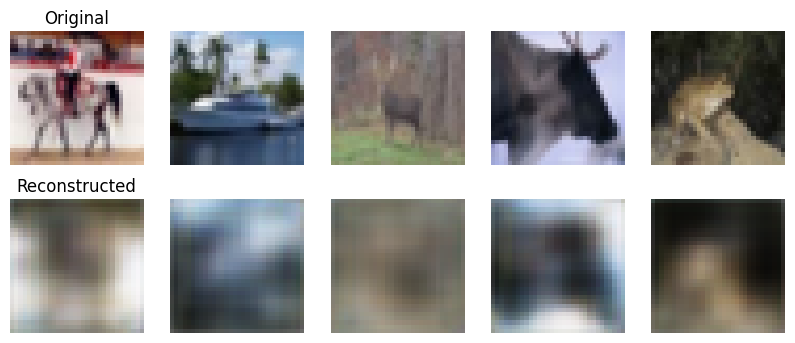

In [ ]:

# Function to visualize original and reconstructed images
def visualize_results(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.axis('off')
        if i == 0:
            plt.title("Original")

        # Reconstructed
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.axis('off')
        if i == 0:
            plt.title("Reconstructed")

    plt.show()

# Reconstruct images
reconstructed_images = autoencoder.predict(X)

# Visualize original and reconstructed images
visualize_results(X, reconstructed_images)